In [34]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

## Paso 2: Cargando los datos

In [42]:
amazon = pd.read_csv('amazon.tsv', sep='\t')
num_rows = len(amazon)

midpoint = num_rows // 4

amazon = amazon.iloc[:midpoint]

## Paso 3: Limpieza y Exploración de los Datos

Hay 49784 títulos únicos en el dataset.

El top 10 de títulos con más repeticiones es: product_title
Natural Cures "They" Don't Want You to Know about                         493
The FairTax Book                                                          449
Eldest (Inheritance, Book 2)                                              249
Harry Potter and the Half-Blood Prince (Book 6)                           195
The Historian                                                             152
100 People Who Are Screwing Up America (And Al Franken Is #37)            122
Unfit For Command: Swift Boat Veterans Speak Out Against John Kerry       113
The Kite Runner                                                           106
Freakonomics: A Rogue Economist Explores the Hidden Side of Everything    104
The Game: Penetrating the Secret Society of Pickup Artists                103
dtype: int64


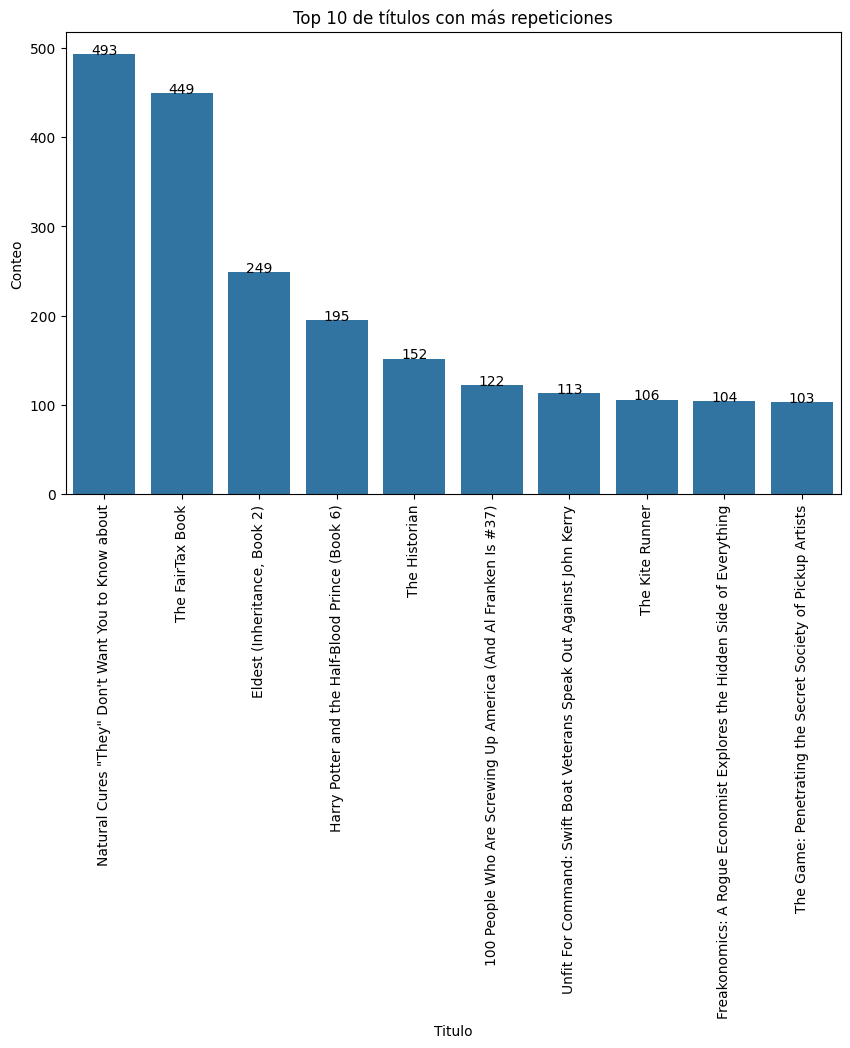

In [43]:
# Eliminar duplicados
amazon = amazon.drop_duplicates()

# Eliminar filas con valores nulos
amazon = amazon.dropna()

# Pasar la fecha al tipo de dato correcto
amazon['review_date'] = pd.to_datetime(amazon['review_date'])

# Eliminar columnas que no aportan información
amazon = amazon.drop(columns=['marketplace', 'product_category'])

# Tratamiento de valores atípicos
def detectar_y_tratar_valores_atipicos(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Ajustar valores atípicos
    df[col] = np.where(df[col] < limite_inferior, limite_inferior, df[col])
    df[col] = np.where(df[col] > limite_superior, limite_superior, df[col])

    return df

amazon = detectar_y_tratar_valores_atipicos(amazon, 'helpful_votes')
amazon = detectar_y_tratar_valores_atipicos(amazon, 'total_votes')
amazon = detectar_y_tratar_valores_atipicos(amazon, 'star_rating')

amazon.describe()

# Agrupar por titulo y contar el número de repeticiones
titulos = amazon.groupby('product_title')
titulos = titulos.size().sort_values(ascending=False)
print(f"Hay {len(titulos)} títulos únicos en el dataset.")
print()
print(f"El top 10 de títulos con más repeticiones es: {titulos.head(10)}")

# Utilizaremos barplot para visualizar esta información
conteo_titulos_df = pd.DataFrame([titulos]).T.reset_index()
conteo_titulos_df.columns = ['Titulo', 'Conteo']
conteo_titulos_df = conteo_titulos_df.sort_values(by='Conteo', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Titulo', y='Conteo', data=conteo_titulos_df.head(10))
plt.title('Top 10 de títulos con más repeticiones')
for indice, fila in conteo_titulos_df.head(10).iterrows():
    plt.text(indice, fila['Conteo'], fila['Conteo'], color='black', ha="center")
plt.xticks(rotation=90)
plt.show()

In [44]:
# Numeros de estrellas 
estrellas = amazon.groupby('star_rating')
estrellas = estrellas.size().sort_values(ascending=False)
print(f"Hay {len(estrellas)} estrellas únicas en el dataset.")
print()
print(f"El top 4 de estrellas con más repeticiones es: {estrellas.head(4)}")

print()

# Compra verificada
verificado = amazon.groupby('verified_purchase')
verificado = verificado.size().sort_values(ascending=False)
print(f"Hay {len(verificado)} valores únicos en la columna verified_purchase.")
print()
print(f"El top 2 de valores con más repeticiones en la columna verified_purchase es: {verificado.head(2)}")



Hay 4 estrellas únicas en el dataset.

El top 4 de estrellas con más repeticiones es: star_rating
5.0    45031
4.0    14776
2.5     9081
3.0     6096
dtype: int64

Hay 2 valores únicos en la columna verified_purchase.

El top 2 de valores con más repeticiones en la columna verified_purchase es: verified_purchase
N    63156
Y    11828
dtype: int64


## Paso 4: Transformando los datos

In [45]:
estrellas = amazon['star_rating'].unique()

for estrella in estrellas: 
    amazon[estrella] = amazon['star_rating'].transform(lambda x: 1 if x == estrella else 0)

amazon[estrellas].head()



,4.0,3.0,5.0,2.5
0,1,0,0,0
1,0,1,0,0
2,1,0,0,0
3,0,0,1,0
4,1,0,0,0


In [46]:
# Crear columnas para cada valor de la columna verified_purchase
compra_verificada = pd.get_dummies(amazon['verified_purchase'])
compra_verificada.head()

# Transformar la columna 'Y' a 1 si es una compra verificada y 0 si no lo es
compra_verificada['Y'] = np.where(amazon['verified_purchase'] == 'Y', 1, 0)
compra_verificada['N'] = np.where(amazon['verified_purchase'] == 'N', 1, 0)

In [47]:
amazon_caracteristicas = pd.concat([amazon[estrellas], compra_verificada], axis=1)
amazon_caracteristicas.head()

,4.0,3.0,5.0,2.5,N,Y
0,1,0,0,0,1,0
1,0,1,0,0,1,0
2,1,0,0,0,1,0
3,0,0,1,0,1,0
4,1,0,0,0,1,0


# Paso 5: Construyendo un sistema de recomendación utilizando similitud Coseno

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

sim_coseno = cosine_similarity(amazon_caracteristicas, amazon_caracteristicas)

In [49]:
print(f"Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: {sim_coseno.shape}")

Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: (74984, 74984)


In [50]:
from fuzzywuzzy import process

def encuentra_libro(title):
    all_titles = amazon['product_title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [74]:
title = encuentra_libro('Rian')
print(f"El titulo correcto de la pelicula es: {title}:")

El titulo correcto de la pelicula es: The Historian:


In [75]:
book_idx = dict(zip(amazon['product_title'], list(amazon.index)))
idx = book_idx[title]
print(f"El indice de la pelicula {title} en la matriz movie_idx es: {idx}")

El indice de la pelicula The Historian en la matriz movie_idx es: 74958


In [76]:
numero_recomendaciones=10
sim_scores = list(enumerate(sim_coseno[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(numero_recomendaciones+1)]
similar_books = [i[0] for i in sim_scores]

In [77]:
print(f"Por que leiste el libro {title}, te pueden interesar los siguientes {numero_recomendaciones} libros:")
amazon['product_title'].iloc[similar_books]

Por que leiste el libro The Historian, te pueden interesar los siguientes 10 libros:


2                Eisenhorn (A Warhammer 40,000 Omnibus)
4     The Psychology of Proof: Deductive Reasoning i...
5                                The Catcher in the Rye
6     Bait and Switch: The (Futile) Pursuit of the A...
7     Opening Combination Padlocks: No Tools, No Pro...
9                            Hour Game (King & Maxwell)
12               Acts of War: Behavior of Men in Battle
15    Photoshop for Nature Photographers: A Workshop...
23               A Breath of Snow and Ashes (Outlander)
26                                 Eragon (Inheritance)
Name: product_title, dtype: object

In [78]:
title = encuentra_libro('The FairTax Book')  # Corrige el título de prueba
print(f"El título correcto del libro es: {title}")

# Mapea títulos de libros a índices en el DataFrame
book_idx = dict(zip(amazon['product_title'], list(amazon.index)))
idx = book_idx[title]
print(f"El índice del libro {title} en la matriz book_idx es: {idx}")

# Número de recomendaciones a generar
numero_recomendaciones = 10

# Obtiene las puntuaciones de similitud para el libro especificado
sim_scores = list(enumerate(sim_coseno[idx]))

# Ordena las puntuaciones de similitud en orden descendente
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

# Obtiene los índices de los libros más similares, excluyendo el mismo libro
sim_scores = sim_scores[1:(numero_recomendaciones+1)]
similar_books = [i[0] for i in sim_scores]

# Imprime las recomendaciones
print(f"Porque leíste el libro {title}, te pueden interesar los siguientes {numero_recomendaciones} libros:")
print(amazon['product_title'].iloc[similar_books])

El título correcto del libro es: The FairTax Book
El índice del libro The FairTax Book en la matriz book_idx es: 74349
Porque leíste el libro The FairTax Book, te pueden interesar los siguientes 10 libros:
10                                      Faith is a Verb
13    Temple to the Wind: The Story of America's Gre...
18                                Straight Man: A Novel
19                                    Lipstick's Legacy
20    The Last Heiress (Friarsgate Inheritance, Book 4)
21                   How to Make It Big as a Consultant
22    Millionaire Republican: Why Rich Republicans G...
24    Lincoln's Other White House: The Untold Story ...
25    Let's Face it, Men are @$#%: What Women Can Do...
27    Wings in the Night: Twilight Phantasies / Twil...
Name: product_title, dtype: object
